In [1]:
!pip install pytorch_lightning
!pip install tensorboardX

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 KB 36.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 KB 24.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 KB 2.6 MB/s eta 0:00:00


In [1]:
from collections import namedtuple

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td

import pytorch_lightning as pl

import tqdm
import json
import sklearn.metrics as sm

import tensorboardX as tb
import tensorflow as tf
import datetime, os

import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(31337)

## Create pairs (first track, subsequent track, time)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
data = pd.read_json("/content/drive/MyDrive/data_seminar_04.json", lines=True)

In [8]:
data.head()

,message,timestamp,user,track,time,latency,recommendation,experiments
0,last,2022-06-13 11:39:37.645,4013,18934,0.02,0.000206,NaN,"{'AA': 'T1', 'COLLABORATIVE': 'T1'}"
1,next,2022-06-13 11:39:37.683,9693,29738,1.00,0.000902,3079.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
2,next,2022-06-13 11:39:37.692,9693,3079,0.06,0.000923,20078.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
3,next,2022-06-13 11:39:37.700,9693,20078,1.00,0.000858,12044.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"
4,next,2022-06-13 11:39:37.708,9693,12044,0.00,0.000927,37424.0,"{'AA': 'C', 'COLLABORATIVE': 'C'}"


In [48]:
data["track"].value_counts()

177      1500
171      1389
4205     1368
246      1347
176      1337
         ... 
35798       1
36976       1
24122       1
25586       1
36364       1
Name: track, Length: 19353, dtype: int64

In [3]:
Pair = namedtuple("Session", ["user", "start", "track", "time"])

def get_pairs(user_data):
    pairs = []
    first = None
    for _, row in user_data.sort_values("timestamp").iterrows():
        if first is None:
            first = row["track"]
        else:
            pairs.append(Pair(row["user"], first, row["track"], row["time"]))
        
        if row["message"] == "last":
            first = None
    return pairs

In [4]:
pairs = pd.DataFrame(
    data
    .groupby("user")
    .apply(get_pairs)
    .explode()
    .values
    .tolist(),
    columns=["user", "start", "track", "time"]
)

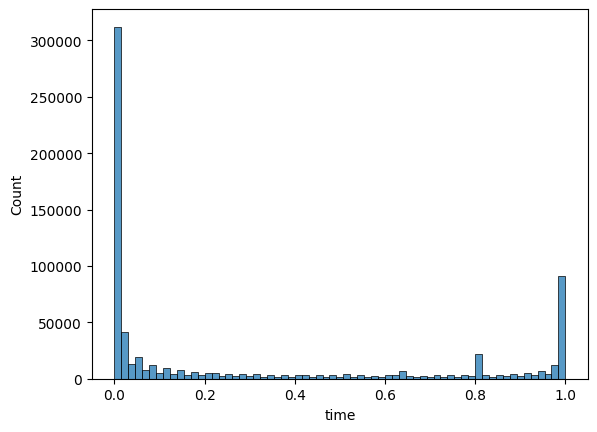

In [5]:
figure, ax = plt.subplots()
sns.histplot(pairs["time"], ax=ax)
pass

## Train Model

In [6]:
rdm = np.random.random(len(pairs))
train_data = pairs[rdm < 0.8]
val_data = pairs[(rdm >= 0.8) & (rdm < 0.9)]
test_data = pairs[rdm >= 0.9]

len(train_data), len(val_data), len(test_data)

(572587, 70915, 71742)

In [45]:
class ContextualRanker(pl.LightningModule):
    def __init__(self, embedding_dim=10):
        super().__init__()
        self.embedding_dim = embedding_dim
        
        # We won't have embeddings for everything, but that's ok
        self.track = nn.Embedding(num_embeddings=50000, embedding_dim=self.embedding_dim)
        self.similarity = nn.CosineSimilarity(dim=-1)

    def forward(self, x):
        embeds = self.track(x[:, 0:2])
        context, track = embeds[:, 0], embeds[:, 1]
        return self.similarity(context, track)
            
    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        loss = F.mse_loss(predictions, y.float(), reduction='mean')
        self.log(metric, loss, prog_bar=prog_bar)
        return loss

    def test_step(self, batch, batch_idx, prog_bar=False):
        x, y = batch
        predictions = self.forward(x)
        targets = y[:, 0].float()
        avgs = y[:, 1].float()
        rdms = y[:, 2].float()

        loss = F.mse_loss(predictions, targets, reduction='mean')
        avg_loss = F.mse_loss(avgs, targets, reduction='mean')
        rdm_loss = F.mse_loss(rdms, targets, reduction='mean')

        self.log("test_loss", loss, prog_bar=prog_bar)
        self.log("avg_loss", avg_loss, prog_bar=prog_bar)
        self.log("rdm_loss", rdm_loss, prog_bar=prog_bar)

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss")
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss", True)
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [46]:
class ContextualRankerData(pl.LightningDataModule):
  def __init__(self, train_data, val_data, test_data, features):
      super().__init__()
      self.train_data = train_data
      self.val_data = val_data
      self.test_data = test_data
      self.features = features

  def prepare_data(self):
      self.test_data = self.test_data.assign(rdm = np.random.random(len(self.test_data))).assign(avg = self.train_data["time"].mean())

  def setup(self, stage=None):
      if stage == "fit" or stage is None:
        self.train_dataset = td.TensorDataset(
            torch.from_numpy(self.train_data[self.features].values), 
            torch.from_numpy(self.train_data["time"].values)
            )

        self.val_dataset = td.TensorDataset(
            torch.from_numpy(self.val_data[self.features].values), 
            torch.from_numpy(self.val_data["time"].values)
            )
        
      if stage == "test" or stage is None:  
        self.test_dataset = td.TensorDataset(
            torch.from_numpy(self.test_data[self.features].values),
            torch.from_numpy(self.test_data[["time", "avg", "rdm"]].values)
        )
  def train_dataloader(self):
      return td.DataLoader(self.train_dataset, batch_size=2048, shuffle=True, num_workers=0)

  def val_dataloader(self):
      return td.DataLoader(self.val_dataset, batch_size=2048, num_workers=0)

  def test_dataloader(self):
      return td.DataLoader(self.test_dataset, batch_size=512, shuffle=False, num_workers=0)

In [47]:
net = ContextualRanker(embedding_dim=100)
data_module = ContextualRankerData(train_data, val_data, test_data, features = ["start", "track"])

checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss")

trainer = pl.Trainer(
    max_epochs=300,
    accelerator='gpu', 
    devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=5),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        checkpoint_callback
    ])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [48]:
trainer.fit(
    net, 
    data_module
)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type             | Params
------------------------------------------------
0 | context    | Embedding        | 5.0 M 
1 | track      | Embedding        | 5.0 M 
2 | linear     | Linear           | 201   
3 | similarity | CosineSimilarity | 0     
------------------------------------------------
10.0 M    Trainable params
0         Non-trainable params
10.0 M    Total params
40.001    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00037: reducing learning rate of group 0 to 1.0000e-04.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Epoch 00046: reducing learning rate of group 0 to 1.0000e-05.


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [49]:
best = ContextualRanker.load_from_checkpoint(checkpoint_callback.best_model_path, embedding_dim=100)

In [50]:
trainer.test(best, data_module)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         avg_loss          │    0.15447917580604553    │
│         rdm_loss          │    0.27573180198669434    │
│         test_loss         │    0.09859360009431839    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.09859360009431839,
  'avg_loss': 0.15447917580604553,
  'rdm_loss': 0.27573180198669434}]

In [53]:
!zip -r /content/best.zip /content/lightning_logs/version_14/

updating: content/lightning_logs/version_14/ (stored 0%)
updating: content/lightning_logs/version_14/checkpoints/ (stored 0%)
updating: content/lightning_logs/version_14/events.out.tfevents.1680966297.0b6b1637464a.12857.9 (deflated 69%)
updating: content/lightning_logs/version_14/events.out.tfevents.1680966710.0b6b1637464a.12857.10 (deflated 26%)
updating: content/lightning_logs/version_14/hparams.yaml (stored 0%)
  adding: content/lightning_logs/version_14/checkpoints/epoch=43-step=12320.ckpt (deflated 19%)


## Compute top recommendations

In [54]:
track_meta = pd.read_json("/content/drive/MyDrive/tracks.json", lines=True)

In [55]:
# context_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()
track_embeddings = dict(best.named_parameters())["track.weight"].data.cpu().numpy()

In [ ]:
track_meta.head()

In [56]:
from numpy.linalg import norm

In [61]:
norm(np.ones((2, 10)), axis=-1)

array([3.16227766, 3.16227766])

In [60]:
print(np.ones((2, 10)))

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


In [73]:
def get_cosine_diffs(track_embeddings, embedding, EPS=1e-6):
    dot = np.dot(track_embeddings, embedding.T)
    dot = dot / (np.maximum(norm(track_embeddings, axis=-1) * norm(embedding, axis=-1), EPS))
    return dot

In [75]:
get_cosine_diffs(np.ones((2, 10)), np.zeros((1, 10)))

array([[0., 0.],
       [0., 0.]])

In [76]:
k = 100
with open("/content/drive/MyDrive/tracks_with_recs_cos.json", "w") as rf:
    for _, track in tqdm.tqdm(track_meta.iterrows()):
        embedding = track_embeddings[track["track"]]
        neighbours = np.argpartition(-get_cosine_diffs(track_embeddings, embedding), k)[:k]
        
        recommendation = dict(track)
        recommendation["recommendations"] = neighbours.tolist()
        
        rf.write(json.dumps(recommendation) + "\n")

Streaming output truncated to the last 5000 lines.
30686it [15:33, 31.02it/s]
30690it [15:33, 31.74it/s]
30694it [15:33, 31.52it/s]
30698it [15:33, 33.12it/s]
30702it [15:33, 34.04it/s]
30706it [15:33, 34.26it/s]
30711it [15:33, 36.99it/s]
30715it [15:34, 34.49it/s]
30719it [15:34, 34.81it/s]
30723it [15:34, 34.97it/s]
30727it [15:34, 35.64it/s]
30731it [15:34, 36.51it/s]
30735it [15:34, 36.60it/s]
30739it [15:34, 36.30it/s]
30744it [15:34, 39.47it/s]
30748it [15:34, 38.51it/s]
30752it [15:35, 36.37it/s]
30756it [15:35, 35.93it/s]
30760it [15:35, 36.13it/s]
30765it [15:35, 39.00it/s]
30769it [15:35, 36.92it/s]
30773it [15:35, 36.14it/s]
30777it [15:35, 34.98it/s]
30781it [15:35, 36.17it/s]
30785it [15:36, 35.99it/s]
30789it [15:36, 36.42it/s]
30793it [15:36, 33.94it/s]
30798it [15:36, 37.24it/s]
30802it [15:36, 37.46it/s]
30806it [15:36, 37.28it/s]
30811it [15:36, 39.09it/s]
30815it [15:36, 39.21it/s]
30820it [15:36, 41.17it/s]
30825it [15:37, 39.52it/s]
30830it [15:37, 40.88it/s]
3083

In [77]:
track = 3916
embedding = track_embeddings[track]
track_meta.loc[track_meta["track"] == track, ["artist", "title"]]

,artist,title
3916,Florence + The Machine,Bird Song


In [78]:
k = 10
neighbours = np.argpartition(-get_cosine_diffs(track_embeddings, embedding), k)[:k]
track_meta.loc[track_meta["track"].isin(neighbours), ["artist", "title"]]

,artist,title
1133,Florence + The Machine,Kiss With A Fist
1525,Florence + The Machine,Rabbit Heart (Raise It Up)
3728,Florence + The Machine,Hardest Of Hearts
3734,Florence + The Machine,My Boy Builds Coffins
3916,Florence + The Machine,Bird Song
18077,Buscemi,L.O.V.E. (feat Joy Adegoke)
24809,V V Brown,Crying Blood
27472,Lights,Saviour (Album Version)
29360,Dido,The Day Before The Day
48218,Jamie Cullum,Oh God
